# **Animal Image Classification Analysis (15%)**

> Indented block


For the non-competition mode, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals. 

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 112 pixels wide by 112 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories. 

-------
1. "Transfer" Learning (ie use a model pre-trained another dataset)
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out. 
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, etc.


###Analysis Report
1. An introduction showing your understanding of the research topic and of the baseline model.

2. A description of modified aspects of the system to improve performance via an "ablation study" table.

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost.

4. Limitations/Conclusions.

In [1]:
# Importing libraries. 

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# Importing FLOPS counter functions
import FLOPs_counter as floops

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# # Mounting G-Drive to get your dataset. 
# # To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU. 
# # Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971 
# from google.colab import drive
# drive.mount('/content/drive')

# # Dataset path. You should change the dataset path to the location that you place the data.
# data_dir = '/content/drive/MyDrive/Datasets/animal/dataset/dataset'
# classes = os.listdir(data_dir)

In [2]:
# Read in dataset 
# REPLACE WITH YOUR FILE PATH
data_dir = '{your_file_name}animal/dataset/dataset'
classes = os.listdir(data_dir)

In [8]:
# Performing Image Transformations. 
## Data Augmentation applied here, e.g. RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(448),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),  
            transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
])


In [9]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 4418


In [10]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [11]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  ailurus-fulgens (5)


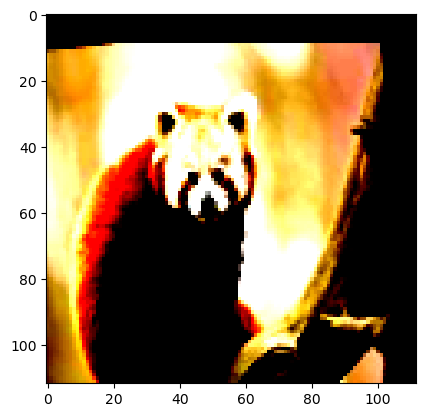

In [12]:
show_image(*dataset[200])

In [13]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [14]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(3757, 220, 441)

In [15]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


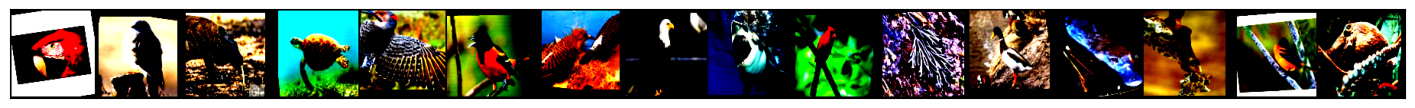

In [16]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [17]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)

        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
    
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [20]:
input_size = 3*112*112
output_size = 151

In [22]:
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes = classes
        self.conv1 = nn.Conv2d(3, 64, 5, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, 3, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*5*5, self.num_classes)

    def forward(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn3(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn4(self.conv4(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 128*5*5)
        X = self.dropout(X)
        X = self.fc1(X)
        
        return F.log_softmax(X, dim=1)

In [23]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
#model.cuda()

In [24]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-6.3205, -5.2629, -4.7436, -4.9680, -7.5778, -5.9287, -5.7455, -5.1311,
        -5.7939, -4.6544, -6.0413, -5.2541, -5.5575, -5.2814, -4.3630, -4.6881,
        -5.6920, -5.3372, -6.3483, -7.8455, -4.9201, -5.3187, -5.2512, -6.6933,
        -4.6900, -5.8745, -3.8164, -4.2994, -6.0180, -4.8105, -5.5120, -4.4907,
        -4.1728, -5.1402, -6.6072, -5.5489, -5.5499, -4.9460, -4.1594, -5.0678,
        -5.4805, -6.9664, -5.7471, -5.5797, -4.5395, -3.5220, -4.7479, -5.3813,
        -5.2832, -4.8749, -5.7646, -5.4693, -6.0413, -6.4103, -4.9654, -7.0572,
        -5.9458, -4.4788, -6.0446, -5.3097, -6.4823, -5.4120, -4.5362, -4.6617,
        -6.2862, -5.5590, -4.1284, -5.1103, -6.1078, -4.3443, -4.5125, -4.8871,
        -4.2250, -6.2399, -5.4804, -6.8640, -6.7175, -4.5569, -7.4041, -4.1308,
        -5.4030, -6.3352, -6.4893, -6.5392, -5.5499, -5.0572, -6.0538, -5.1104,
        -5.4512, -5.7188, -5.9792, 

In [25]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [26]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(model, device)

In [ ]:
history=[evaluate(model, val_loader)]
history

In [32]:
# Hints: The following parameters can be changed to improve the accuracy
# print(test_size)
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

### TRANSFER LEARNING

In [29]:
from torchvision import models

class TransferLearningModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [30]:
# Create the model
transfer_model = TransferLearningModel(num_classes)
transfer_model = to_device(transfer_model, device)

# Pre-train the model with transfer learning in 5 epochs using new dataset
transfer_history = [evaluate(transfer_model, val_loader)]
transfer_history

[{'val_loss': 5.700173377990723, 'val_acc': 0.013392857275903225}]

In [ ]:
# Train the model with existing dataset
transfer_history += fit(num_epochs, lr, transfer_model, train_dl, val_dl, opt_func)

In [ ]:
plot_accuracies(transfer_history)

In [ ]:
plot_losses(transfer_history)

In [ ]:
# Evaluate the transfer learning model
evaluate(transfer_model, test_loader)

### FLOPs

In [ ]:
  # #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  # #Download the code.
  # !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  # !mv download FLOPs_counter.py
  # #!rm -rf download

In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(transfer_model, input, detail=False)